In [203]:
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import matplotlib.pyplot as plt
warnings.simplefilter(action="ignore", category=FutureWarning)


**MY WRANGLE FUNCTION AND FILTERING CODES**

In [123]:
def wrangle(filepath, sep):
    df = pd.read_csv(filepath, sep=';')

    # we will be working with the recordings fpr "P2" only
    df = df[df['value_type'] == 'P2']

    # we need only timestamp and the P2 readings
    df = df.pivot_table(index='timestamp', columns='value_type', values='value')

    # we need to convert the timestamp to date time as its still in object dtype
    df.reset_index(inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # converting the timestamp back to index so as to make it my designated timezone
    df.set_index('timestamp', inplace=True)
    df.index = df.index.tz_convert('Africa/Nairobi')

    # resampling the data to 1 hour interval
    y = df['P2'].resample('1H').mean().fillna(method='ffill')
    return y


**READING IN MY DATA**

In [124]:
y = wrangle(r'C:\Users\USER\Desktop\PROJECTS\air- quality in nairobi.csv', sep=';')
y


C:\Users\USER\AppData\Local\Temp\ipykernel_8396\2324041182.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = df['P2'].resample('1H').mean().fillna(method='ffill')
C:\Users\USER\AppData\Local\Temp\ipykernel_8396\2324041182.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['P2'].resample('1H').mean().fillna(method='ffill')


timestamp
2018-04-01 03:00:00+03:00    4.310455
2018-04-01 04:00:00+03:00    4.125000
2018-04-01 05:00:00+03:00    4.057273
2018-04-01 06:00:00+03:00    5.235714
2018-04-01 07:00:00+03:00    7.658333
                               ...   
2018-04-30 22:00:00+03:00    2.459149
2018-04-30 23:00:00+03:00    2.444255
2018-05-01 00:00:00+03:00    2.378889
2018-05-01 01:00:00+03:00    1.751667
2018-05-01 02:00:00+03:00    1.420435
Freq: h, Name: P2, Length: 720, dtype: float64

**CHECKING HOW MANY HOURS IN THE PAST CAN WE PREDICT THE FUTURE USING SHIFT METHOD**

In [ ]:
print(y.corr(y.shift(0)))
print(y.corr(y.shift(1)))
print(y.corr(y.shift(2)))  # as we shift back in one hour interval prediction strength decreases
print(y.corr(y.shift(3)))
print(y.corr(y.shift(4)))


1.0
0.5993365956915958
0.37294502035290283
0.21582192682325096
0.1276488168981976


**USING THE AUTO CORRELATION FUNCTION TO VIEW HOW MANY HOURS WE CAN PREDICT THE DATA USING ACF**

Text(0, 0.5, 'Correlation Coefficient')

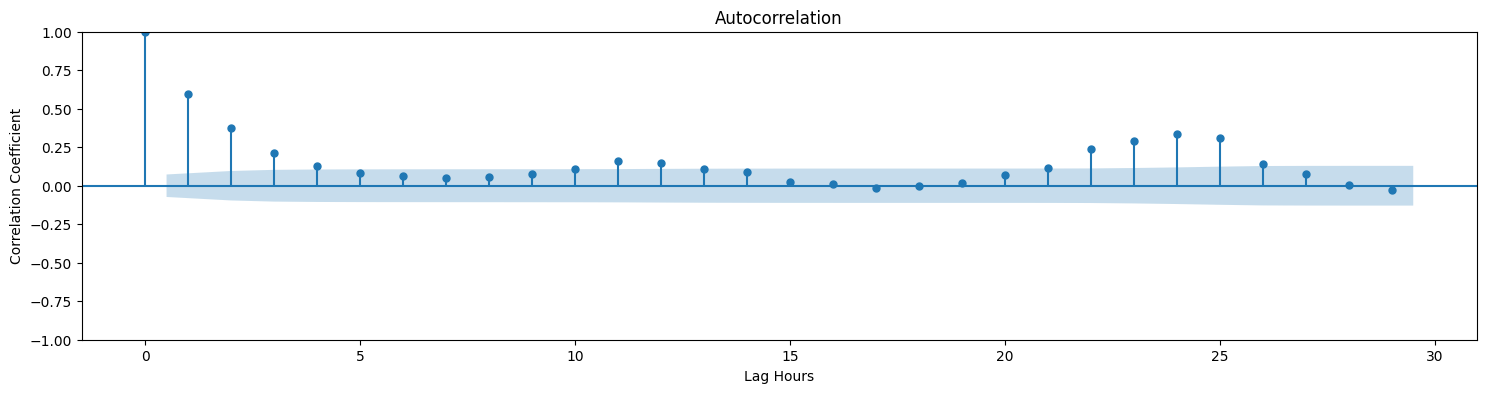

In [ ]:
fig, ax= plt.subplots(figsize=(18, 4))
plot_acf(y, ax=ax)               # we can see a little bit of pop at Hour 11, 12 and 22 to 25
plt.xlabel('Lag Hours')
plt.ylabel('Correlation Coefficient')


**LETS SEE HOW FAR WE CAN GO BACK IN TIME USING PACF**

Text(0, 0.5, 'Correlation Coefficient')

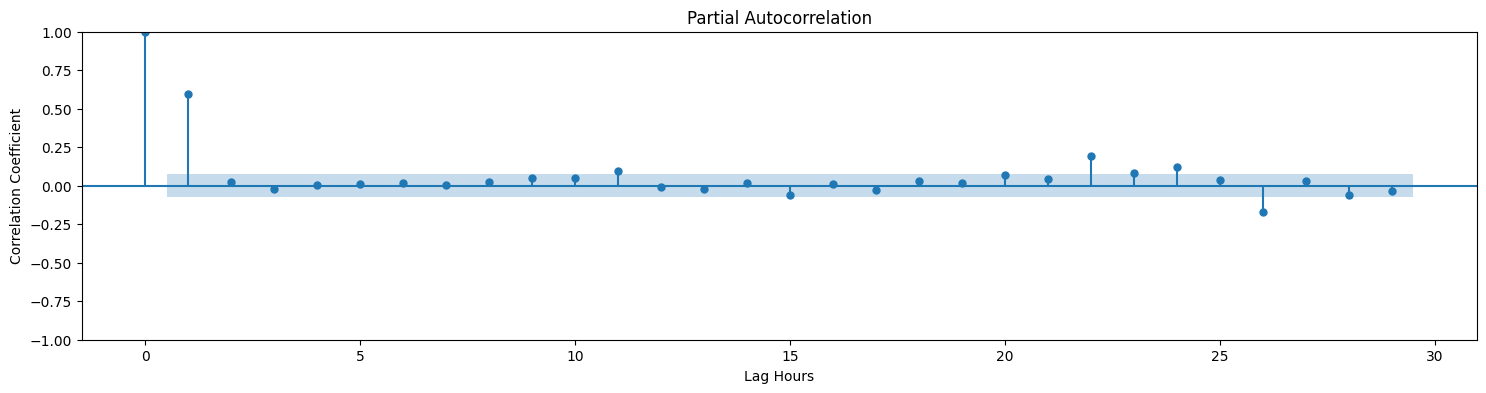

In [ ]:
fig, ax = plt.subplots(figsize = (18, 4))
plot_pacf(y, ax=ax)         # we have seen beyond 26 there's nothing to predict with so our lag hours will stop as 26 hours
plt.xlabel('Lag Hours')
plt.ylabel('Correlation Coefficient')


**SPLITTING THE DATA**

In [289]:
cut_off = int(len(y) * 0.7)
y_train = y.iloc[:cut_off]  # we don't have a feature so we have to split the target column into training and testing set
y_test = y.iloc[cut_off:]

len(y_train) + len(y_test) == len(y)


True

**BUILDING THE MODEL**

In [290]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print('y_train_mean :', round(y_train_mean, 2))
print('y_pred_baseline :', y_pred_baseline[:5])
print('mae_baseline :', round(mae_baseline, 2))


y_train_mean : 10.82
y_pred_baseline : [10.821254630746925, 10.821254630746925, 10.821254630746925, 10.821254630746925, 10.821254630746925]
mae_baseline : 6.32


**MODEL**

In [291]:
model = AutoReg(y_train, lags=26).fit() # fitting the model with the 26 hour lag
#model.predict().isna().sum()  # viewing the null rows after fitting shows the same 26 rows fitted

y_pred = model.predict().dropna()
mae_training = mean_absolute_error(y_train[26:], y_pred)
mae_training   # good thing we are beating the mean_absolute_error baseline


4.360660770384922

**CALCULATING RESIDUALS**

timestamp
2018-04-21 21:00:00+03:00    5.920517
2018-04-21 22:00:00+03:00    2.406762
2018-04-21 23:00:00+03:00    4.880023
2018-04-22 00:00:00+03:00   -1.227243
2018-04-22 01:00:00+03:00    2.273034
Freq: h, dtype: float64

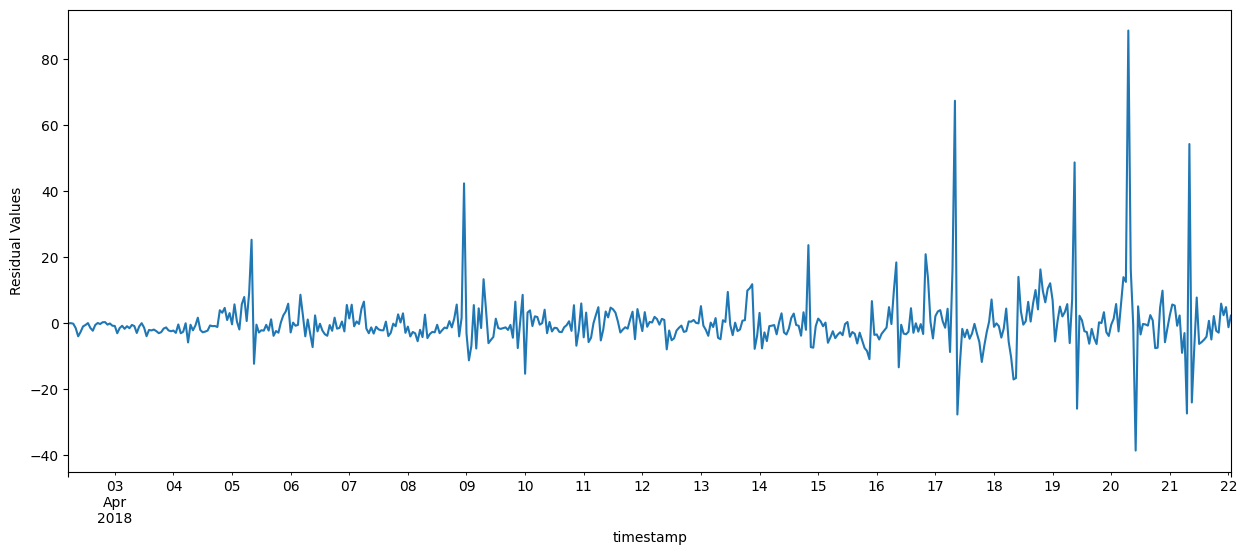

In [292]:
y_train_resid = model.resid
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax, ylabel='Residual Values')
y_train_resid.tail()


**HISTPLOT OF RESIDUALS**

<Axes: title={'center': 'AR 26 distribution of residuals'}, xlabel='Residual values', ylabel='Frequency'>

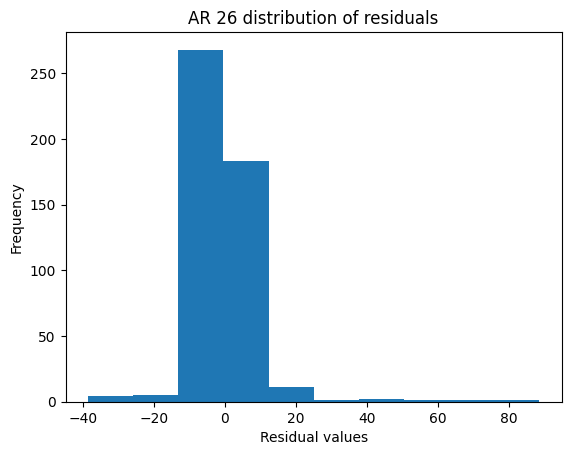

In [293]:
y_train_resid.plot(kind='hist', xlabel='Residual values', title='AR 26 distribution of residuals')


**ACF PLOT OF RESIDUALS**

Text(0, 0.5, 'Correlation CAoefficient')

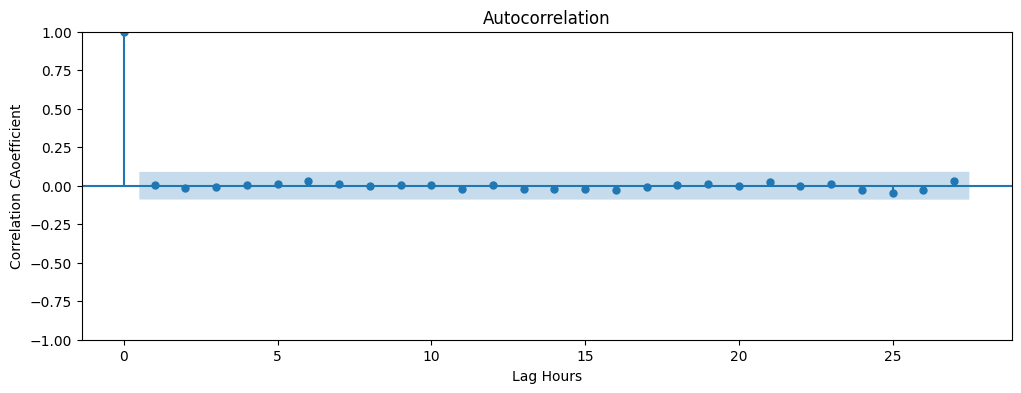

In [294]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(y_train_resid, ax=ax)   #plot looks ok because our correlation coefficients markers are inside the blue band
plt.xlabel('Lag Hours')
plt.ylabel('Correlation CAoefficient')


**EVALUATING OUR MODEL**


In [295]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
mae_testing = mean_absolute_error(y_test, y_pred_test)   # this shows an issue judging how far its from our baseline and mae training
print('mae testing :', round(mae_testing, 2))


mae testing : 5.17


**CREATE A DICTIONARY FOR Y_TEST AND Y_PRED_TEST AND PUT IT IN A DATAFRAME**

In [296]:
df_pred_test = pd.DataFrame({
            'y_test':y_test,
            'y_pred':y_pred_test
}, index = y_test.index)
df_pred_test


,y_test,y_pred
timestamp,,
2018-04-22 02:00:00+03:00,10.566471,15.257971
2018-04-22 03:00:00+03:00,10.205000,14.807258
2018-04-22 04:00:00+03:00,10.542500,24.790699
2018-04-22 05:00:00+03:00,11.818889,13.016097
2018-04-22 06:00:00+03:00,14.297667,33.113077
...,...,...
2018-04-30 22:00:00+03:00,2.459149,11.752977
2018-04-30 23:00:00+03:00,2.444255,11.823281
2018-05-01 00:00:00+03:00,2.378889,11.891093


In [297]:
fig = px.line(df_pred_test, labels={'values':'P2'})
fig.show()
# our data is making its own prediction on unactual data thats why the chart is like that , its started from 26 data points and as its moving forward its erecting its own data points 
# which isn't reliable we will fix it using walk forward validation


**WALKFORWARD VALIDATION**

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]]) 

    

**VIEWING THE DF_PRED_TEST TO MAKE SURE THE CHANGES WERE MADE**

In [311]:
df_pred_test = pd.DataFrame({
            'y_test':y_test,
            'y_pred':y_pred_wfv
}, index = y_test.index)
df_pred_test


,y_test,y_pred
timestamp,,
2018-04-22 02:00:00+03:00,10.566471,15.257971
2018-04-22 03:00:00+03:00,10.205000,12.816530
2018-04-22 04:00:00+03:00,10.542500,22.462544
2018-04-22 05:00:00+03:00,11.818889,6.510487
2018-04-22 06:00:00+03:00,14.297667,31.437960
...,...,...
2018-04-30 22:00:00+03:00,2.459149,4.439549
2018-04-30 23:00:00+03:00,2.444255,4.342103
2018-05-01 00:00:00+03:00,2.378889,4.897684


**VIEWING THE TEST MAE AFTER THE WALK FORWARD VALIDATION WAS IMPLEMENTED**

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))  #the new test mean_absolute_error is now below train_mae which shows corrections being made


Test MAE (walk forward validation): 3.44


**OUR PREDICTION LOOKS NICE NOW**

In [312]:
fig = px.line(df_pred_test, labels={'values':'P2'})
fig.show()
